# Predictions

In [1]:
import duckdb
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

import repl_utils
from variables import Variables as vars

plt.style.use("../../notebook.mplstyle")

START_TIME = datetime.now()
OUTPUT_DIR = f"output/0011-model-predictions-1/{START_TIME:%Y%m%d-%H%M%S}"

SAVE_PLOTS = True

os.makedirs(OUTPUT_DIR, exist_ok=True)

repl_utils.print_environment_info()

print(f"\n--------------------\nOutput directory: {OUTPUT_DIR}\n--------------------\n")

-------------------- Environment Information --------------------
date: 2026-01-02T21:49:56.462010
platform: Windows-11-10.0.26220-SP0
platform_version: 10.0.26220
cpu: Intel64 Family 6 Model 197 Stepping 2, GenuineIntel
cores: 16
physical_cores: 16
ram: 95 GB
ram_available: 74 GB
cuda: False
cuda_device_count: 0
cuda_device_0: False
python: 3.13.11 | packaged by conda-forge | (main, Dec  6 2025, 11:10:00) [MSC v.1944 64 bit (AMD64)]
numpy: 2.3.5
pandas: 2.3.3
scipy: 1.16.3
sklearn: 1.8.0
lightgbm: 4.6.0
pytorch: 2.9.1
pymc: 5.27.0
pytensor: 2.36.1
arviz: 0.23.0

--------------------
Output directory: output/0011-model-predictions-1/20260102-214956
--------------------



In [2]:
con = duckdb.connect("./data/us_births.db", read_only=True)

## 3.1. Births predicted from 2016 to 2024

In [3]:
df = con.execute(
    f"""
    SELECT
        b.year,
        sum(b.down_ind) as down_ind,
        sum(b.p_ds_lb_pred_01) as down_pred,
        sum(b.p_ds_lb_pred_01)  / sum(b.down_ind) as ratio,
        sum(b.p_ds_lb_nt * (1 - r.reduction)) as ds_lb_est_reduc
    FROM us_births AS b
    LEFT JOIN reduction_rate_year r
        ON b.year = r.year
    WHERE b.year >= 2016
    GROUP BY b.year
    ORDER BY b.year;
    """
).df()
df

,year,down_ind,down_pred,ratio,ds_lb_est_reduc
0,2016,2168.0,2088.671828,0.963410,5128.850913
1,2017,2044.0,2018.934672,0.987737,5170.826289
2,2018,2108.0,2024.182589,0.960238,5035.392182
3,2019,2030.0,2002.051046,0.986232,5069.181474
4,2020,1954.0,1937.895350,0.991758,4915.527694
5,2021,1903.0,1940.361850,1.019633,5037.277999
6,2022,1861.0,1896.075519,1.018848,5137.556006
7,2023,1855.0,1905.005407,1.026957,5065.777423
8,2024,1886.0,1917.470720,1.016686,5137.562776


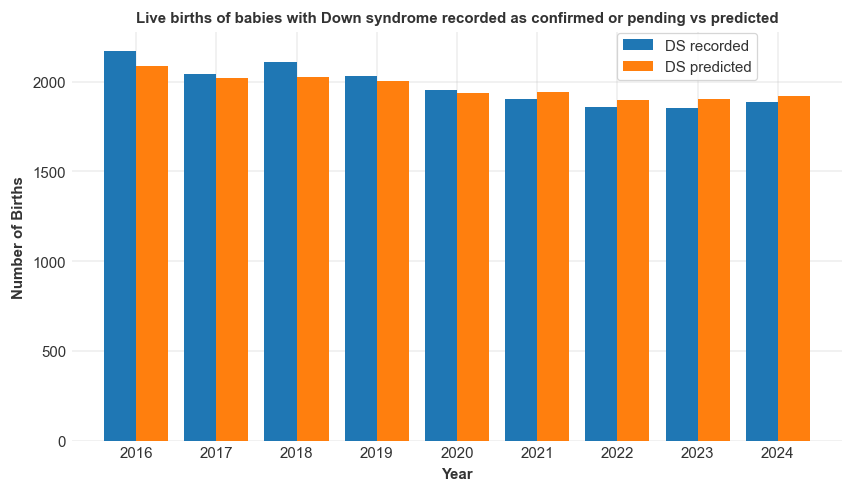

In [4]:
plt.figure(figsize=(7,4))
# plt.fill_between(range(2003, 2015), 2250, color="#d8f0ff", alpha=0.4)
plt.bar(df["year"] - 0.2, df["down_ind"], width=0.4, label="DS recorded")
plt.bar(df["year"] + 0.2, df["down_pred"], width=0.4, label="DS predicted")
plt.xlim(2015.2, 2024.8)
plt.xticks(range(2016, 2025))
plt.xlabel("Year")
plt.ylabel("Number of Births")
plt.title("Live births of babies with Down syndrome recorded as confirmed or pending vs predicted")
plt.legend(bbox_to_anchor=(0.9, 0.94), loc="center right")
if SAVE_PLOTS:
    plt.savefig(os.path.join(OUTPUT_DIR, "births_recorded_predicted.png"), dpi=300, bbox_inches="tight")
    plt.savefig(os.path.join(OUTPUT_DIR, "births_recorded_predicted.svg"), bbox_inches="tight")
plt.show()

In [5]:
df = con.execute(
    f"""
    SELECT
        b.year,
        sum(b.down_ind) as down_ind,
        sum(b.p_ds_lb_pred_01) as down_pred,
        sum(b.p_ds_lb_nt * (1 - r.reduction)) as ds_lb_est_reduc
    FROM us_births AS b
    LEFT JOIN reduction_rate_year r
        ON b.year = r.year
    WHERE b.year >= 2016 AND b.down_ind = 0
    GROUP BY b.year
    ORDER BY b.year;
    """
).df()
df

,year,down_ind,down_pred,ds_lb_est_reduc
0,2016,0.0,2021.118688,5111.012154
1,2017,0.0,1959.267975,5155.650107
2,2018,0.0,1961.487721,5018.470155
3,2019,0.0,1936.295625,5052.617216
4,2020,0.0,1876.511324,4900.264834
5,2021,0.0,1889.955390,5018.596411
6,2022,0.0,1844.384678,5118.570609
7,2023,0.0,1856.679831,5045.127121
8,2024,0.0,1865.445928,5115.747782


In [27]:
df = con.execute(
    f"""
    SELECT
        b.year,
        SUM(b.down_ind) AS down_ind,
        (SELECT COUNT(*) FROM us_births WHERE year = b.year AND p_ds_lb_pred_01 >= 0.029) AS down_pred,
        SUM(b.p_ds_lb_nt * (1 - r.reduction)) AS ds_lb_est_reduc
    FROM us_births AS b
    LEFT JOIN reduction_rate_year r
        ON b.year = r.year
    WHERE b.year >= 2016
    GROUP BY b.year
    ORDER BY b.year;
    """
).df()
df

,year,down_ind,down_pred,ds_lb_est_reduc
0,2016,2168.0,5160,5128.850913
1,2017,2044.0,5040,5170.826289
2,2018,2108.0,5202,5035.392182
3,2019,2030.0,5032,5069.181474
4,2020,1954.0,4937,4915.527694
5,2021,1903.0,4712,5037.277999
6,2022,1861.0,4352,5137.556006
7,2023,1855.0,4401,5065.777423
8,2024,1886.0,4547,5137.562776


In [ ]:
con.close()